# Criando modelo de Machine Learning

## Carregamento dos pacotes iniciais

Apesar de ter exportado um arquivo CSV, vou consultar diretamente o banco de dados para melhorar meu conhecimento

In [1]:
#!pip install mysql-connector-python
#!pip install pyyaml

In [2]:
import pandas as pd
import numpy as np
from mysql.connector import connect, Error
import yaml

## Definição e conexão

Vou usar a leitura de um arquivo yaml apesar de não ser boa prática armazenar senhas em arquivos estáticos

In [3]:
with open('login.yml', 'r') as l:
    acesso_yml=yaml.safe_load(l)

conn = connect(**acesso_yml)

In [4]:
base_estudo = pd.read_sql(sql="select * from analise_risco.base_emprestimo_analise", con = conn)
conn.close()
base_estudo.head()

,id_solicitante,id_emprestimo,id_historico,idade_solicitante,salario_solicitante,situacao_propriedade,tempo_trabalhado,motivo,pontuacao,valor_solicitado,taxa_juros,percentual_renda,flag_inadimplencia,anos_primeira_solicitacao,flag_inadimplencia_hist
0,02x9biGh-3gTR,k9lhNtMp-72zH,6EM4uoS2-maX2,23.0,68000.0,Alugada,1.0,Empreendimento,E,14400.0,17.99,0.21,1.0,2,0
1,05AU2u3q-jNEJ,2jgsNDsK-S45I,2nr9qAH9-x2vh,25.0,45000.0,Alugada,0.0,Empreendimento,C,10000.0,12.98,0.22,0.0,2,1
2,05o7RxO7-9LhQ,G7ebJZJb-6GDu,1zlTwsfS-0pan,23.0,65000.0,Alugada,2.0,Pagamento de débitos,B,3600.0,11.49,0.06,0.0,2,0
3,08rX5Qdc-ufb0,0sFrQD5Y-agj2,6rafzTfN-8awI,23.0,45312.0,Alugada,3.0,Educativo,A,13500.0,7.88,0.30,0.0,3,0
4,095kmLry-GPTX,eIoa76FA-d0FH,3ph8dE3U-L5I7,22.0,64000.0,Alugada,6.0,Educativo,A,7000.0,5.79,0.11,0.0,3,0


In [5]:
print('A base de estudo possui {} registros e {} colunas.'.format(base_estudo.shape[0] ,base_estudo.shape[1]))

A base de estudo possui 34485 registros e 15 colunas.


In [6]:
base_estudo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34485 entries, 0 to 34484
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id_solicitante             34485 non-null  object 
 1   id_emprestimo              34485 non-null  object 
 2   id_historico               34485 non-null  object 
 3   idade_solicitante          34165 non-null  float64
 4   salario_solicitante        34150 non-null  float64
 5   situacao_propriedade       34485 non-null  object 
 6   tempo_trabalhado           33231 non-null  float64
 7   motivo                     34485 non-null  object 
 8   pontuacao                  34485 non-null  object 
 9   valor_solicitado           34154 non-null  float64
 10  taxa_juros                 30859 non-null  float64
 11  percentual_renda           34170 non-null  float64
 12  flag_inadimplencia         34142 non-null  float64
 13  anos_primeira_solicitacao  34485 non-null  int

É possível identificar que temos variáveis com dados nulos

In [7]:
base_estudo.isnull().sum()

id_solicitante                  0
id_emprestimo                   0
id_historico                    0
idade_solicitante             320
salario_solicitante           335
situacao_propriedade            0
tempo_trabalhado             1254
motivo                          0
pontuacao                       0
valor_solicitado              331
taxa_juros                   3626
percentual_renda              315
flag_inadimplencia            343
anos_primeira_solicitacao       0
flag_inadimplencia_hist         0
dtype: int64

In [8]:
base_estudo.id_solicitante.value_counts()

vw62YkOj-Hhds    1
tzp27oIJ-giry    1
5Q84Ydme-uXoa    1
afuT3wND-rACG    1
fO03z60C-1CSW    1
                ..
wSHOaz08-eKX6    1
W9LMpy9O-SMRo    1
bOdAaBfS-T23p    1
6zLLFTDS-43PE    1
y0K0YnkI-D4wz    1
Name: id_solicitante, Length: 34485, dtype: int64

## Tratamento de dados nulos e análise de outliers

In [9]:
import seaborn as sns

Para esse estudo, decido remover todos os registros que possuem algum dado nulo. Apesar de alguns campos serem possíveis calcular (como por exemplo `valor_solicitado`, `salario_solicitante`, `percentual_renda`) e outros inferir (`tempo_trabalho`). Após ter o modelo pronto, irei usar essa base como uma segunda validação

In [10]:
base_bad = base_estudo.drop(base_estudo.dropna().index)

In [11]:
base_tratada = base_estudo.dropna().copy()

In [12]:
base_tratada.columns

Index(['id_solicitante', 'id_emprestimo', 'id_historico', 'idade_solicitante',
       'salario_solicitante', 'situacao_propriedade', 'tempo_trabalhado',
       'motivo', 'pontuacao', 'valor_solicitado', 'taxa_juros',
       'percentual_renda', 'flag_inadimplencia', 'anos_primeira_solicitacao',
       'flag_inadimplencia_hist'],
      dtype='object')

### Idade solicitante

De acordo com o dicionário de dados, este é o campo com a idade (em anos) do solicitante de empréstimo

In [13]:
base_tratada.idade_solicitante.describe()

count    28882.000000
mean        27.728862
std          6.309004
min         20.000000
25%         23.000000
50%         26.000000
75%         30.000000
max        144.000000
Name: idade_solicitante, dtype: float64

<AxesSubplot:ylabel='idade_solicitante'>

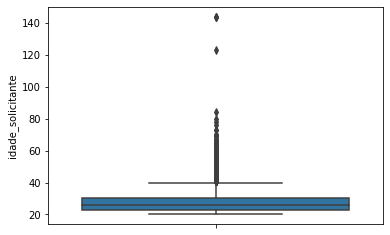

In [14]:
sns.boxplot(data=base_tratada, y='idade_solicitante')

Decido então estabelecer o limite de idade em 80. Acima disso retirarei deste estudo.

Para as idades não informadas, em um primeiro momento eu penso em definir como 20 (que é o mínimo desta base) e acrescentar o tempo trabalhado e assim formar uma idade. Para não ter problema com o modelo, irei separar estes clientes e depois testá-lo no modelo utilizando esta premissa de idade. Farei o mesmo para as idades dispares.

In [15]:
base_tratada.query('idade_solicitante.isnull() or idade_solicitante >= 80', engine='python').index

Int64Index([6641, 8469, 16410, 21550, 27123, 27766], dtype='int64')

In [16]:
base_teste_idade = base_tratada.query('idade_solicitante.isnull() or idade_solicitante >= 80', engine='python')
base_tratada.drop(base_teste_idade.index, inplace=True)

### Salário do solicitante

In [17]:
base_tratada.salario_solicitante.describe().apply("{0:.1f}".format)

count      28876.0
mean       66381.3
std        51434.7
min         4000.0
25%        39381.0
50%        55755.0
75%        80000.0
max      2039784.0
Name: salario_solicitante, dtype: object

<AxesSubplot:ylabel='salario_solicitante'>

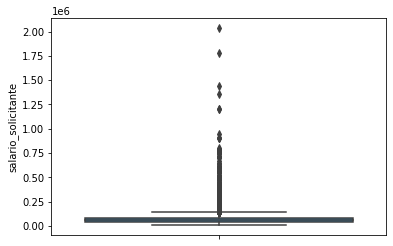

In [18]:
sns.boxplot(data=base_tratada, y='salario_solicitante')

A princípio não irei remover o outlier de salário, verei a relação com as outras variáveis para decidir. Já para os salários não informados, irei utilizar a coluna `percentual_renda` na base _badP_ que criei. De acordo com o dicionário de dados esta coluna representa a _renda percentual entre o valor total do empréstimo e o salário anual_

### Situação Propriedade

De acordo com o dicionário de dados, é situação da propriedade que o solicitante possui. Como esta variável não possui dados nulos e já foi traduzida na origem, irei seguir para a próxima variável

In [19]:
base_tratada.situacao_propriedade.value_counts()

Alugada       14620
Hipotecada    11855
Própria        2204
Outros          197
Name: situacao_propriedade, dtype: int64

### Tempo Trabalhado

O tempo de trabalho, em anos, que o solicitante possui

In [20]:
base_tratada.tempo_trabalhado.describe()

count    28876.000000
mean         4.787644
std          4.154246
min          0.000000
25%          2.000000
50%          4.000000
75%          7.000000
max        123.000000
Name: tempo_trabalhado, dtype: float64

<AxesSubplot:ylabel='tempo_trabalhado'>

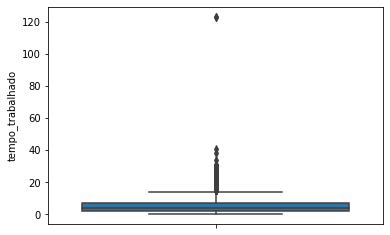

In [21]:
sns.boxplot(data=base_tratada, y='tempo_trabalhado')

Temos pelo menos duas situações que necessitam de correção:
1. Tempo de trabalho maior ou igual ao tempo de vida
1. Tempo de trabalho nulo

In [22]:
ix_tempo_invalido = base_tratada.query('tempo_trabalhado >= idade_solicitante', engine='python').index

<AxesSubplot:ylabel='tempo_trabalhado'>

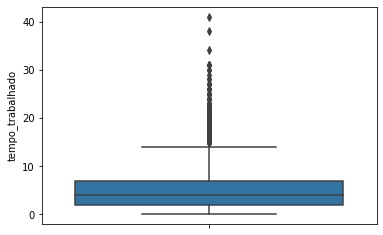

In [23]:
sns.boxplot(data=base_tratada.drop(index=ix_tempo_invalido), y='tempo_trabalhado')

In [24]:
base_teste_tempo_trabalhado = base_tratada.loc[ix_tempo_invalido]
base_tratada.drop(index=ix_tempo_invalido, inplace=True)

### Motivo

Motivo do empréstimo

In [25]:
base_tratada.motivo.value_counts()

Educativo               5728
Médico                  5318
Empreendimento          5022
Pessoal                 4899
Pagamento de débitos    4595
Melhora do lar          3210
Outros                   102
Name: motivo, dtype: int64

### Pontuação

É a pontuação de empréstimos

In [26]:
base_tratada.pontuacao.value_counts()

A    9451
B    9188
C    5732
D    3257
E     874
F     211
      102
G      59
Name: pontuacao, dtype: int64

In [27]:
base_tratada.query('pontuacao == ""')

,id_solicitante,id_emprestimo,id_historico,idade_solicitante,salario_solicitante,situacao_propriedade,tempo_trabalhado,motivo,pontuacao,valor_solicitado,taxa_juros,percentual_renda,flag_inadimplencia,anos_primeira_solicitacao,flag_inadimplencia_hist
396,cJgwA3tE-AY4M,JLGJfrzw-MGWa,2HTnbMk1-nQeW,38.0,48000.0,Hipotecada,23.0,Médico,,18250.0,11.11,0.19,0.0,4,
852,KoyFBbks-gi45,7O6L2fZB-oDZe,5krLhjYZ-fpEb,33.0,21000.0,Alugada,0.0,Outros,,12000.0,10.39,0.40,1.0,9,0
916,lyUgjRNf-Hjp9,AJBQgakp-AMbu,6Z79o9wP-uPWl,27.0,44000.0,Hipotecada,2.0,Médico,,7500.0,10.59,0.14,0.0,3,0
1235,sQDATdCY-DIaN,D6Xyg742-6LfN,3gifNtWw-QoxQ,38.0,200000.0,Hipotecada,2.0,Outros,,15000.0,10.37,0.24,0.0,6,0
1275,tgqDm8dC-dirP,9kbfXZw4-Zpu8,0Fn8LtfN-jgvy,38.0,22000.0,Outros,2.0,Pagamento de débitos,,25000.0,13.43,0.17,0.0,17,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31844,NvSSqfRK-KBNw,wCJSKXkH-dNff,eR6vMeph-tUPf,23.0,50000.0,Alugada,0.0,Empreendimento,,5000.0,12.98,0.14,1.0,3,
32442,xc3EN6rE-DrN9,NdrT5OeK-EOZx,fXj5Mlny-9O97,24.0,35000.0,Hipotecada,3.0,Outros,,35000.0,13.99,0.21,0.0,14,1
33146,QGd0EgPs-qD56,0kaEza3S-6n0H,xnq6PMYC-sf0Y,24.0,56000.0,Alugada,0.0,Empreendimento,,15000.0,15.33,0.39,0.0,3,
33693,RCuhJUxp-BUvw,lC7xOxg4-S49I,8T6ZIyLK-jc0e,22.0,36000.0,Alugada,1.0,Educativo,,15000.0,12.84,0.33,1.0,3,


Como não sabemos ainda a forma de classificação desta pontuação, decido retirar os registros inválidos

In [28]:
ix_pontuacao_invalida = base_tratada.query('pontuacao == ""').index
base_teste_pontuacao = base_tratada.loc[ix_pontuacao_invalida]
base_tratada.drop(index=ix_pontuacao_invalida, inplace=True)

### Valor solicitado

In [29]:
base_tratada.valor_solicitado.describe()

count    28772.000000
mean      9655.593111
std       6327.386227
min        500.000000
25%       5000.000000
50%       8000.000000
75%      12500.000000
max      35000.000000
Name: valor_solicitado, dtype: float64

### Taxa de juros

<AxesSubplot:ylabel='taxa_juros'>

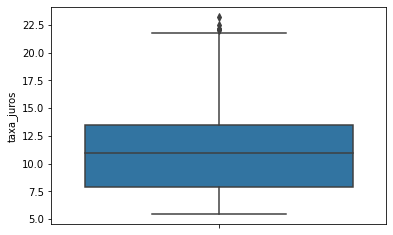

In [30]:
sns.boxplot(data=base_tratada, y='taxa_juros')

### Percentual de renda

<AxesSubplot:ylabel='percentual_renda'>

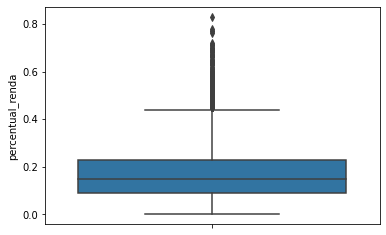

In [31]:
sns.boxplot(data=base_tratada, y='percentual_renda')

Empréstimos pesados...

### Flag inadimplencia

In [32]:
base_tratada.flag_inadimplencia.value_counts()

0.0    22526
1.0     6246
Name: flag_inadimplencia, dtype: int64

In [33]:
base_tratada.flag_inadimplencia.unique()

array([1., 0.])

### Anos primeira solicitação

<AxesSubplot:ylabel='anos_primeira_solicitacao'>

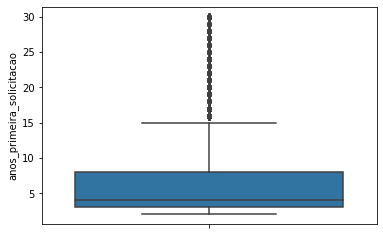

In [34]:
sns.boxplot(data=base_tratada, y='anos_primeira_solicitacao')

In [35]:
base_tratada.query("anos_primeira_solicitacao >= idade_solicitante")

,id_solicitante,id_emprestimo,id_historico,idade_solicitante,salario_solicitante,situacao_propriedade,tempo_trabalhado,motivo,pontuacao,valor_solicitado,taxa_juros,percentual_renda,flag_inadimplencia,anos_primeira_solicitacao,flag_inadimplencia_hist


### Flag inadimplencia histórica

In [36]:
base_tratada.flag_inadimplencia_hist.value_counts()

0    23576
1     5117
        79
Name: flag_inadimplencia_hist, dtype: int64

Vou replicar essas informações

In [37]:
base_tratada.query('flag_inadimplencia_hist == ""')[['flag_inadimplencia', 'flag_inadimplencia_hist']]

,flag_inadimplencia,flag_inadimplencia_hist
398,0.0,
501,1.0,
1260,1.0,
1436,0.0,
2832,0.0,
...,...,...
30301,0.0,
31448,1.0,
31607,0.0,
33548,1.0,


In [38]:
ix_flag_inad_hist_nula = base_tratada.query('flag_inadimplencia_hist == ""').index

In [39]:
base_tratada.loc[ix_flag_inad_hist_nula, 'flag_inadimplencia_hist'] = base_tratada.loc[ix_flag_inad_hist_nula, 'flag_inadimplencia'].astype('int64')

In [40]:
base_tratada.flag_inadimplencia_hist = base_tratada.flag_inadimplencia_hist.astype('int64')

In [41]:
base_tratada.flag_inadimplencia_hist.value_counts()

0    23632
1     5140
Name: flag_inadimplencia_hist, dtype: int64

## Visualização dos dados